In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import os

In [2]:
os.chdir(r"G:\2023-纵向\停车分配\strategy")
os.getcwd()

'G:\\2023-纵向\\停车分配\\strategy'

In [16]:
so = np.load("../save_data/03-14-18-14/S_NK_total.npy")
fcfs = np.load("../save_data/03-14-18-35/S_NK_total.npy")
dp = np.load("../save_data/03-14-18-42/S_NK_total.npy")
dp_r = np.load("../save_data/03-14-18-51/S_NK_total.npy")

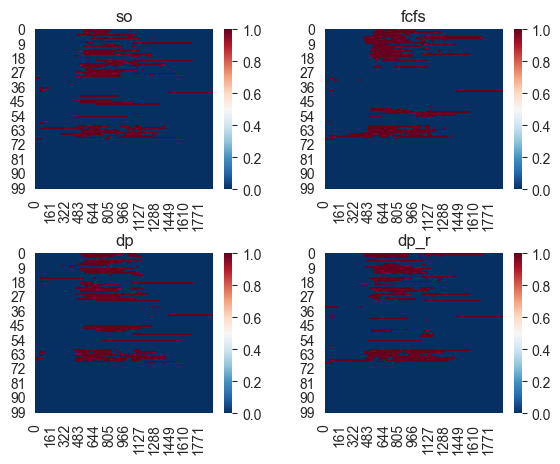

<Figure size 1000x1000 with 0 Axes>

In [24]:
# 占有率
fig,axes = plt.subplots(2,2)
sns.heatmap(data=so,cmap="RdBu_r",ax=axes[0,0])
axes[0,0].set_title("so")

axes[0,1].set_title("fcfs")
sns.heatmap(data=fcfs[len(fcfs)-1],cmap="RdBu_r",ax=axes[0,1])

axes[1,0].set_title("dp")
sns.heatmap(data=dp[len(dp)-1],cmap="RdBu_r",ax=axes[1,0])

axes[1,1].set_title("dp_r")
sns.heatmap(data=dp_r[len(dp_r)-1],cmap="RdBu_r",ax=axes[1,1])
# 调整子图的间距
plt.subplots_adjust(left=0.1,  # 左边距
                    bottom=0.1,  # 底边距
                    right=0.9,  # 右边距
                    top=0.9,  # 顶边距
                    wspace=0.3,  # 子图之间的水平间距
                    hspace=0.4)  # 子图之间的垂直间距
plt.figure(figsize=(10,10))
plt.show()

In [63]:
# 计算dpr的收益和成本
# 1. 加载数据
dpr_assign = pd.read_csv("../save_data/03-14-18-51/assign_info.csv")
req_info = pd.read_csv("100-0.1-so.csv")
rmk = np.load("r_mk.npy")
# 2. 计算临时收益
park_fee = 3 / 60
charge_fee = 1.5
reserve_fee = 1
activity_t = np.sum(rmk,axis=1)
temp_revenue = [ (activity_t[i] * (park_fee+charge_fee*req_info['label'].iloc[i]) +  reserve_fee) for i in range(len(activity_t))]
# 3. 对多次分配的请求删除合并，计算收益
dpr_assign_filter = dpr_assign.loc[dpr_assign.groupby('req_id')['assign_t'].idxmax()]
revenue = {'req_id':np.arange(0,110),'revenue':temp_revenue}
revenue_df = pd.DataFrame(revenue)
dpr_assign_filter_merge = pd.merge(dpr_assign_filter,revenue_df,on='req_id',how='left')
# 4. 计算步行时间并
cost_matrix = [[3, 5, 1, 5],
                        [3, 5, 3, 3],
                        [5, 3, 10, 1],
                        [5, 3, 5, 10]]
walk_cost = []
for i in range(len(dpr_assign_filter)):
    temp_o = req_info['O'].loc[dpr_assign_filter['req_id'].iloc[i]]
    temp_d = req_info['D'].loc[dpr_assign_filter['req_id'].iloc[i]]
    temp_pl = dpr_assign_filter['pl_num'].iloc[i]
    walk_cost.append(cost_matrix[temp_pl][temp_o] + 2 * cost_matrix[temp_pl][temp_d+2])
dpr_assign_filter_merge['walk_cost'] = walk_cost
# 5. 计算各类收益
charge_index = req_info[req_info['label']==1].index.tolist()
park_index= req_info[req_info['label']==0].index.tolist()
charge_revenue = dpr_assign_filter_merge[dpr_assign_filter_merge['req_id'].isin(charge_index)]['revenue'].sum()
park_revenue = dpr_assign_filter_merge[dpr_assign_filter_merge['req_id'].isin(park_index)]['revenue'].sum()
average_walk_cost = dpr_assign_filter_merge['walk_cost'].sum() / len(dpr_assign_filter_merge)
print(charge_revenue)
print(park_revenue)
print(average_walk_cost)

1347.65
1130.6500000000003
6.14


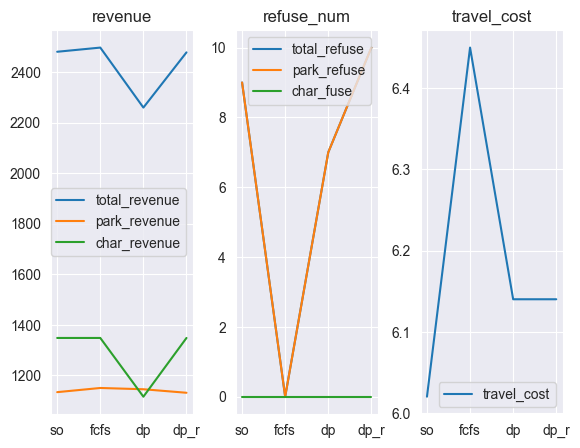

<Figure size 800x800 with 0 Axes>

In [77]:
# 各类指标
fig,axes = plt.subplots(1,3)

axes[0].plot([2480.74,2497.25,2259.74,2478.3],label='total_revenue')
axes[0].plot([1133.09,1149.60,1144.59,1130.65],label='park_revenue')
axes[0].plot([1347.64,1347.65,1115.15,1347.65],label='char_revenue')
axes[0].set_xticks(range(0, 4))  # Set the ticks
axes[0].set_xticklabels(["so",'fcfs','dp','dp_r'])
axes[0].legend()
axes[0].set_title("revenue")

axes[1].plot([9,0,7,10],label='total_refuse')
axes[1].plot([9,0,7,10],label='park_refuse')
axes[1].plot([0,0,0,0],label='char_fuse')
axes[1].set_xticks(range(0, 4))  # Set the ticks
axes[1].set_xticklabels(["so",'fcfs','dp','dp_r'])
axes[1].legend()
axes[1].set_title("refuse_num")

axes[2].plot([6.02,6.45,6.14,6.14],label='travel_cost')
axes[2].set_xticks(range(0, 4))  # Set the ticks
axes[2].set_xticklabels(["so",'fcfs','dp','dp_r'])
axes[2].legend()
axes[2].set_title("travel_cost")

# 调整子图的间距
plt.subplots_adjust(left=0.1,  # 左边距
                    bottom=0.1,  # 底边距
                    right=0.9,  # 右边距
                    top=0.9,  # 顶边距
                    wspace=0.3,  # 子图之间的水平间距
                    hspace=0.4)  # 子图之间的垂直间距
plt.figure(figsize=(8,8))
plt.show()

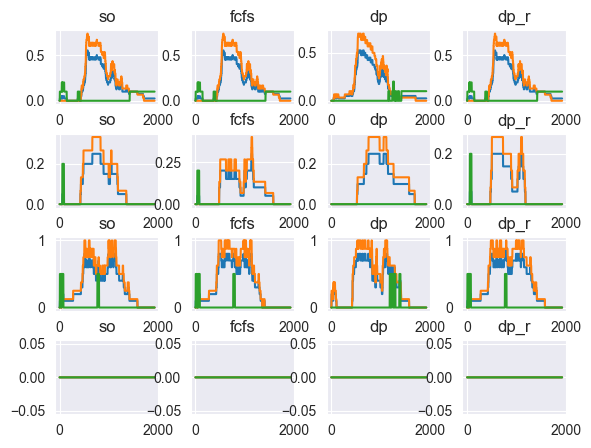

<Figure size 4000x4000 with 0 Axes>

In [108]:
# 各种策略下停车场的占有率时变图
# 1. 计算各停车场的占有率
all_index = [list(range(40)),list(range(40,60)),list(range(60,70)),list(range(70,100))]
ops_index = [list(range(30)),list(range(40,55)),list(range(60,68)),list(range(70,92))]
cps_index = [list(range(30,40)),list(range(55,60)),list(range(68,70)),list(range(92,100))]
total_num = [40,20,10,30]
ordinary_num = [30,15,8,22]
charge_num = [10,5,2,8]
title = ['so','fcfs','dp','dp_r']

data = [so,fcfs[len(fcfs)-1],dp[len(dp)-1],dp_r[len(dp_r)-1]]
fig,axes = plt.subplots(4,4)  # pl_num * [so fcfs dp dpr]
for i in range(4):
    for j in range(4):
        axes[i,j].plot(data[j][all_index[i]].sum(axis=0) / total_num[i],label='all_space')
        axes[i,j].plot(data[j][ops_index[i]].sum(axis=0) /ordinary_num[i],label='ordinary_space')
        axes[i,j].plot(data[j][cps_index[i]].sum(axis=0) / charge_num[i],label='charge_space')
        # axes[i,j].legend(loc='best')
        axes[i,j].set_title(title[j])

# 调整子图的间距
plt.subplots_adjust(left=0.1,  # 左边距
                    bottom=0.1,  # 底边距
                    right=0.9,  # 右边距
                    top=0.9,  # 顶边距
                    wspace=0.3,  # 子图之间的水平间距
                    hspace=0.4)  # 子图之间的垂直间距
plt.figure(figsize=(40,40))
plt.show()

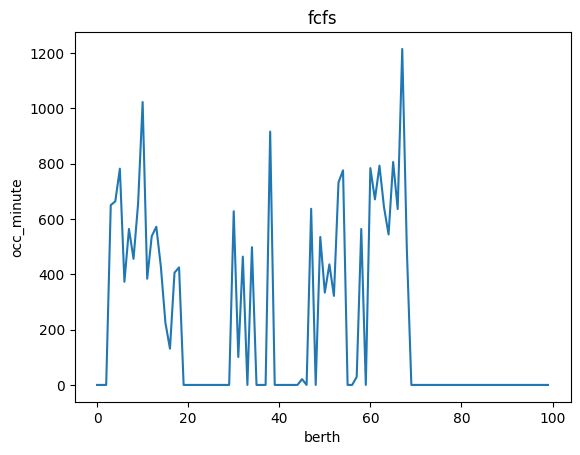

In [52]:
plt.plot(fcfs_new[110].sum(axis=1))
plt.xlabel("berth")
plt.ylabel("occ_minute")
plt.title("fcfs")
plt.show()

In [60]:
sum(sum(so_new[:,:1440]))

20559.0

In [61]:
sum(sum(fcfs_new[110][:,:1440]))

20559.0

In [68]:
OPS_INDEX = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 60, 61, 62, 63, 64, 65, 66, 67, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91]
CPS_INDEX = [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 55, 56, 57, 58, 59, 68, 69, 92, 93, 94, 95, 96, 97, 98, 99]

In [86]:
print("fcfs parking util:")
print(np.sum(fcfs_new[110][OPS_INDEX][:,:]))
print("fcfs charging util:")
print(np.sum(fcfs_new[110][CPS_INDEX][:,:]))
print("so parking util:")
print((np.sum(so_new[OPS_INDEX][:,:])))
print("so charging util:")
print((np.sum(so_new[CPS_INDEX][:,:])))

fcfs parking util:
18160.0
fcfs charging util:
3695.0
so parking util:
20992.0
so charging util:
863.0


In [89]:
20992+863

21855

In [85]:
np.sum(so_new)

21855.0

In [79]:
rmk = np.load("r_mk.npy")
sum(sum(rmk))

21855

In [100]:
req_info = pd.read_csv("100-0.1-so.csv")
decision_interval = 15
req_info = req_info.sort_values(by="request_t")
earliest_request = min(req_info['request_t'])
req_info['request_interval'] = (req_info['request_t']-earliest_request) // decision_interval
req_info

,Unnamed: 0,request_t,arrival_t,activity_t,leave_t,label,request_interval
101,101,-19,5,28,33,1,0
100,100,-10,4,46,50,1,0
103,103,18,43,61,104,1,2
105,105,20,55,32,87,1,2
102,102,27,37,38,75,1,3
...,...,...,...,...,...,...,...
96,96,1236,1281,20,1301,0,83
97,97,1274,1299,16,1315,0,86
98,98,1316,1351,23,1374,0,89
99,99,1327,1382,22,1404,0,89


In [107]:
print(req_info['request_interval'].unique()

0

In [98]:
earliest_request

-19

In [5]:
data = pd.read_csv(r"G:\2023-纵向\停车分配\strategy\100-0.1-so.csv")
data['diff'] = np.random.randint(0,5,len(data))

In [6]:
data

,Unnamed: 0,request_t,arrival_t,activity_t,leave_t,label,diff
0,0,38,48,474,522,0,1
1,1,239,274,463,737,0,4
2,2,407,422,408,830,0,3
3,3,405,430,28,458,0,0
4,4,397,432,563,995,0,1
...,...,...,...,...,...,...,...
105,105,20,55,32,87,1,1
106,106,95,105,38,143,1,0
107,107,333,368,35,403,1,0
108,108,712,767,32,799,1,0


In [20]:
list(np.where(data['diff'].loc[[0,1,2,3,4]] - 1 >0)[0])

[1, 2]

In [16]:
[0,1] + [5,6]

[0, 1, 5, 6]

In [19]:
if 1:
    print(11)

11


In [4]:
test = []


In [5]:
test.append([0,1,2,3])

In [7]:
test.append([5,6,8,9])
test

[[0, 1, 2, 3], [5, 6, 8, 9]]

In [8]:
np.array(test).reshape((-1,4))

array([[0, 1, 2, 3],
       [5, 6, 8, 9]])

In [3]:
test = pd.read_csv("100-0.1-so.csv")
test

,Unnamed: 0,request_t,arrival_t,activity_t,leave_t,label,O,D
0,0,38,48,474,522,0,1,1
1,1,239,274,463,737,0,0,1
2,2,407,422,408,830,0,0,1
3,3,405,430,28,458,0,1,0
4,4,397,432,563,995,0,0,1
...,...,...,...,...,...,...,...,...
105,105,20,55,32,87,1,0,1
106,106,95,105,38,143,1,0,0
107,107,333,368,35,403,1,0,0
108,108,712,767,32,799,1,1,1


In [9]:
test[['O','D']].loc[test['arrival_t']==55].values

array([[0, 0],
       [0, 1]], dtype=int64)

In [10]:
# 新增new_label列
def assign_new_label(row):
    if row['label'] == 0:
        return 0
    elif row['label'] == 1 and row['activity_t'] <= 60:
        return 1
    elif row['label'] == 1 and row['activity_t'] > 60:
        return 2

test['new_label'] = test.apply(assign_new_label, axis=1)
test

,Unnamed: 0,request_t,arrival_t,activity_t,leave_t,label,O,D,new_label
0,0,38,48,474,522,0,1,1,0
1,1,239,274,463,737,0,0,1,0
2,2,407,422,408,830,0,0,1,0
3,3,405,430,28,458,0,1,0,0
4,4,397,432,563,995,0,0,1,0
...,...,...,...,...,...,...,...,...,...
105,105,20,55,32,87,1,0,1,1
106,106,95,105,38,143,1,0,0,1
107,107,333,368,35,403,1,0,0,1
108,108,712,767,32,799,1,1,1,1


In [12]:
# 新增收益列
rmk = np.load("r_mk.npy")
# 2. 计算临时收益
park_fee = 3 / 60
charge_fee = 1.5
reserve_fee = 1
activity_t = np.sum(rmk,axis=1)
temp_revenue = [ (activity_t[i] * (park_fee+charge_fee*test['label'].iloc[i]) +  reserve_fee) for i in range(len(activity_t))]

test['revenue'] = temp_revenue
test

,Unnamed: 0,request_t,arrival_t,activity_t,leave_t,label,O,D,new_label,revenue
0,0,38,48,474,522,0,1,1,0,24.75
1,1,239,274,463,737,0,0,1,0,24.20
2,2,407,422,408,830,0,0,1,0,21.45
3,3,405,430,28,458,0,1,0,0,2.45
4,4,397,432,563,995,0,0,1,0,29.20
...,...,...,...,...,...,...,...,...,...,...
105,105,20,55,32,87,1,0,1,1,52.15
106,106,95,105,38,143,1,0,0,1,61.45
107,107,333,368,35,403,1,0,0,1,56.80
108,108,712,767,32,799,1,1,1,1,52.15


In [15]:
test.to_csv(r"G:\2023-纵向\停车分配\reinforce-learning\new_req_info.csv",index=False)

In [17]:
[list(np.arange(0,5))]

[[0, 1, 2, 3, 4]]

In [2]:
data = pd.read_csv(r"G:\2023-纵向\停车分配\reinforce-learning\new_req_info.csv")
data

,req_id,request_t,arrival_t,activity_t,leave_t,label,O,D,new_label,revenue
0,0,38,48,474,522,0,1,1,0,24.75
1,1,239,274,463,737,0,0,1,0,24.20
2,2,407,422,408,830,0,0,1,0,21.45
3,3,405,430,28,458,0,1,0,0,2.45
4,4,397,432,563,995,0,0,1,0,29.20
...,...,...,...,...,...,...,...,...,...,...
105,105,20,55,32,87,1,0,1,1,52.15
106,106,95,105,38,143,1,0,0,1,61.45
107,107,333,368,35,403,1,0,0,1,56.80
108,108,712,767,32,799,1,1,1,1,52.15


In [10]:
max(data.groupby(['arrival_t'])['arrival_t'].count())

2

In [21]:
data[['new_label','O','D','activity_t']].loc[data['arrival_t']==48].values[0]

array([  0,   1,   1, 474], dtype=int64)

In [13]:
data['arrival_t']

0        48
1       274
2       422
3       430
4       432
       ... 
105      55
106     105
107     368
108     767
109    1423
Name: arrival_t, Length: 110, dtype: int64

In [20]:
import numpy as np

# 创建一个4x4的矩阵示例
matrix = np.array([
    [1, 2, 3, 4],
    [5, 6, 0, 8],
    [9, 10, 11, 12],
    [13, 14, 0, 16]
])

# 找出第三列（即索引为2的列）中值为0的行的索引
zero_rows = np.where(matrix[:, 2] == 0)[0]

print("索引为2的列中值为0的行的索引是:", zero_rows)

索引为2的列中值为0的行的索引是: [1 3]


In [25]:
data.rename({'Unnamed: 0':'req_id'})

,Unnamed: 0,request_t,arrival_t,activity_t,leave_t,label,O,D,new_label,revenue
0,0,38,48,474,522,0,1,1,0,24.75
1,1,239,274,463,737,0,0,1,0,24.20
2,2,407,422,408,830,0,0,1,0,21.45
3,3,405,430,28,458,0,1,0,0,2.45
4,4,397,432,563,995,0,0,1,0,29.20
...,...,...,...,...,...,...,...,...,...,...
105,105,20,55,32,87,1,0,1,1,52.15
106,106,95,105,38,143,1,0,0,1,61.45
107,107,333,368,35,403,1,0,0,1,56.80
108,108,712,767,32,799,1,1,1,1,52.15


In [26]:
data

,Unnamed: 0,request_t,arrival_t,activity_t,leave_t,label,O,D,new_label,revenue
0,0,38,48,474,522,0,1,1,0,24.75
1,1,239,274,463,737,0,0,1,0,24.20
2,2,407,422,408,830,0,0,1,0,21.45
3,3,405,430,28,458,0,1,0,0,2.45
4,4,397,432,563,995,0,0,1,0,29.20
...,...,...,...,...,...,...,...,...,...,...
105,105,20,55,32,87,1,0,1,1,52.15
106,106,95,105,38,143,1,0,0,1,61.45
107,107,333,368,35,403,1,0,0,1,56.80
108,108,712,767,32,799,1,1,1,1,52.15


In [8]:
list(np.arange(0,4))

[0, 1, 2, 3]

In [9]:
np.load(r"G:\2023-纵向\停车分配\strategy\r_mk.npy")

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

In [11]:
data['new_req_id'] = data.index.tolist()
data

,req_id,request_t,arrival_t,activity_t,leave_t,label,O,D,new_label,revenue,new_req_id
0,0,38,48,474,522,0,1,1,0,24.75,0
1,1,239,274,463,737,0,0,1,0,24.20,1
2,2,407,422,408,830,0,0,1,0,21.45,2
3,3,405,430,28,458,0,1,0,0,2.45,3
4,4,397,432,563,995,0,0,1,0,29.20,4
...,...,...,...,...,...,...,...,...,...,...,...
105,105,20,55,32,87,1,0,1,1,52.15,105
106,106,95,105,38,143,1,0,0,1,61.45,106
107,107,333,368,35,403,1,0,0,1,56.80,107
108,108,712,767,32,799,1,1,1,1,52.15,108
